In [4]:
# --- Importing Libraries ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt # we only need pyplot
import warnings
import os
import yellowbrick
import pickle
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix
from yellowbrick.style import set_palette
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.contrib.wrapper import wrap
from matplotlib.collections import PathCollection
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [5]:
cardio = pd.read_csv('cardio_train.csv',delimiter=';')
cardio = cardio.drop(columns=['id'])
cardio.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
duplicate_sum = cardio.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')
    
cardio.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(cardio.shape[0], cardio.shape[1]))

Duplicates Rows in Dataset are : 24
Total 69976 datapoints remaining with 12 features


In [7]:
cardio.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
#cleaning up the dataset by redfining datatset in terms of converting cardio intro a string, calculating age, getting height into proper units and calucalting bmi
cardio[['cardio']] = cardio[['cardio']].astype(str)
cardio['year']= (cardio['age']/365).round(0)
cardio['height(m)']= (cardio['height']/100).round(3)
cardio['BMI']= (cardio['weight']/((cardio['height(m)'])*cardio['height(m)']))
cardio = cardio.drop(columns=['height','age'])

In [9]:
cardio.describe()

,gender,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,year,height(m),BMI
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,1.349648,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,53.338945,1.643592,27.557610
std,0.476862,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,6.765633,0.082112,6.092210
min,1.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,30.000000,0.550000,3.471784
25%,1.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,48.000000,1.590000,23.875115
50%,1.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,54.000000,1.650000,26.391837
75%,2.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,58.000000,1.700000,30.222222
max,2.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,65.000000,2.500000,298.666667


In [10]:
outlier = ((cardio["ap_hi"]>200) | (cardio["ap_lo"]>140) | (cardio["ap_lo"]<50) | (cardio["ap_hi"]<80) | (cardio["height(m)"]<1.4 ) | (cardio["height(m)"]>2.2 ) )
print("There is {} outlier".format(cardio[outlier]["cardio"].count()))

There is 1485 outlier


In [11]:
womendata = cardio[cardio['gender'] == 1]
maledata = cardio[cardio['gender'] == 2]



In [12]:
womendata = womendata.drop(columns=['gender'])
womendata.head()


,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,year,height(m),BMI
1,85.0,140,90,3,1,0,0,1,1,55.0,1.56,34.927679
2,64.0,130,70,3,1,0,0,0,1,52.0,1.65,23.507805
4,56.0,100,60,1,1,0,0,0,0,48.0,1.56,23.011177
5,67.0,120,80,2,2,0,0,0,0,60.0,1.51,29.384676
6,93.0,130,80,3,1,0,0,1,0,61.0,1.57,37.729725


In [41]:
maledata = maledata.drop(columns=['gender'])
maledata.head()

,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,year,height(m),BMI
0,62.0,110,80,1,1,0,0,1,0,50.0,1.68,21.967120
3,82.0,150,100,1,1,0,0,1,1,48.0,1.69,28.710479
7,95.0,130,90,3,3,0,0,1,1,62.0,1.78,29.983588
11,60.0,120,80,1,1,0,0,1,0,52.0,1.73,20.047446
12,60.0,120,80,1,1,0,0,0,0,41.0,1.65,22.038567


In [42]:
maledata.corr()

,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,year,height(m),BMI
weight,1.000000,0.025570,0.036225,0.148457,0.118160,0.014368,0.040238,-0.022157,0.017536,0.409392,0.767198
ap_hi,0.025570,1.000000,0.015180,0.023436,0.005452,-0.005199,0.000262,0.007648,0.009935,0.008355,0.020371
ap_lo,0.036225,0.015180,1.000000,0.023446,0.009791,-0.002437,0.009043,0.003922,0.012025,0.015416,0.026844
cholesterol,0.148457,0.023436,0.023446,1.000000,0.420266,0.031271,0.045507,0.020950,0.135220,0.030954,0.122403
gluc,0.118160,0.005452,0.009791,0.420266,1.000000,-0.002755,0.014205,0.005697,0.091148,0.019079,0.099529
smoke,0.014368,-0.005199,-0.002437,0.031271,-0.002755,1.000000,0.360375,0.047858,-0.061435,0.037542,-0.003631
alco,0.040238,0.000262,0.009043,0.045507,0.014205,0.360375,1.000000,0.038814,-0.036275,0.030805,0.024070
active,-0.022157,0.007648,0.003922,0.020950,0.005697,0.047858,0.038814,1.000000,-0.005972,0.008923,-0.028521
year,0.017536,0.009935,0.012025,0.135220,0.091148,-0.061435,-0.036275,-0.005972,1.000000,-0.085233,0.053273
height(m),0.409392,0.008355,0.015416,0.030954,0.019079,0.037542,0.030805,0.008923,-0.085233,1.000000,-0.166876


In [15]:
womendata.corr()

,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,year,height(m),BMI
weight,1.000000,0.032413,0.045793,0.149595,0.107962,0.026574,0.047977,-0.015796,0.080503,0.161551,0.806084
ap_hi,0.032413,1.000000,0.016702,0.024265,0.015020,-0.001410,0.000556,-0.003866,0.026678,0.000095,0.027669
ap_lo,0.045793,0.016702,1.000000,0.025551,0.012051,0.005032,0.007446,0.005229,0.022313,-0.013089,0.043343
cholesterol,0.149595,0.024265,0.025551,1.000000,0.466011,0.022979,0.045237,0.004727,0.163712,-0.072797,0.152573
gluc,0.107962,0.015020,0.012051,0.466011,1.000000,0.011327,0.017682,-0.012857,0.102039,-0.024584,0.100386
smoke,0.026574,-0.001410,0.005032,0.022979,0.011327,1.000000,0.146517,-0.001258,-0.026748,0.009170,0.021519
alco,0.047977,0.000556,0.007446,0.045237,0.017682,0.146517,1.000000,0.013249,-0.018366,-0.009867,0.043581
active,-0.015796,-0.003866,0.005229,0.004727,-0.012857,-0.001258,0.013249,1.000000,-0.011733,-0.021858,-0.007600
year,0.080503,0.026678,0.022313,0.163712,0.102039,-0.026748,-0.018366,-0.011733,1.000000,-0.078298,0.098070
height(m),0.161551,0.000095,-0.013089,-0.072797,-0.024584,0.009170,-0.009867,-0.021858,-0.078298,1.000000,-0.333852


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6350408719346049

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6416544057544548



<AxesSubplot:>

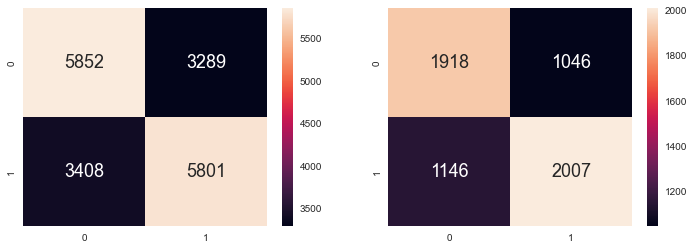

In [16]:
# Extract Response and Predictors
y = pd.DataFrame(maledata['cardio'])
X = pd.DataFrame(maledata[['year', 'cholesterol', 'gluc', 'alco', 'BMI']])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])



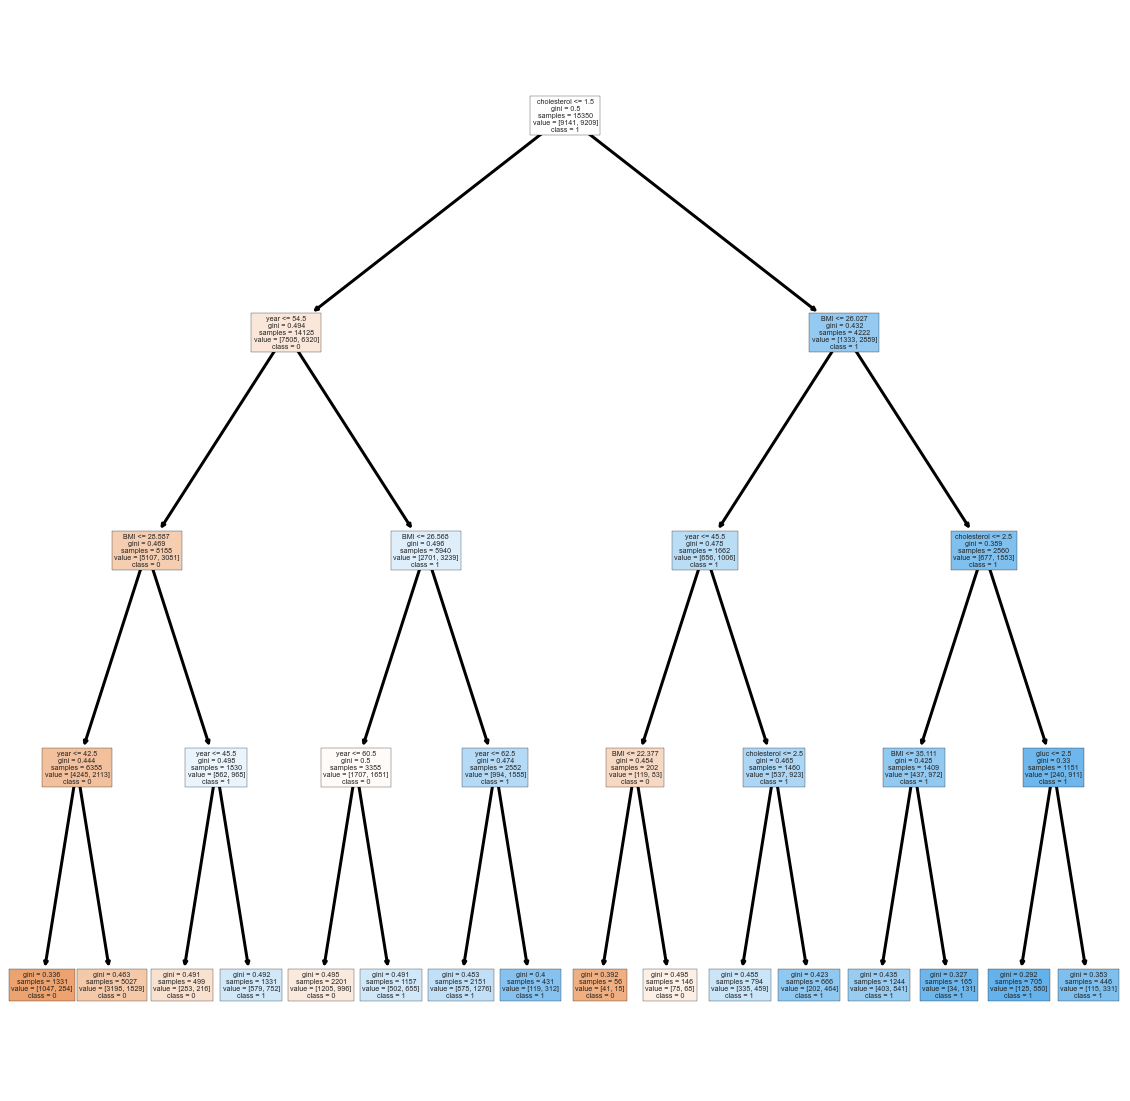

In [17]:
# Plot the Decision Tree
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(20, 20))
out = plot_tree(dectree, 
          feature_names = X_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

<AxesSubplot:xlabel='gender'>

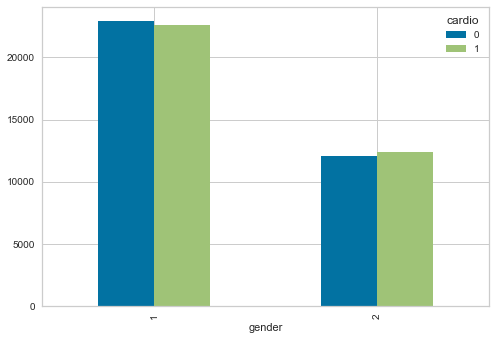

In [18]:
pd.crosstab(cardio.gender,cardio.cardio).plot(kind='bar') 
#2 refers to woman and 1 refers to man

# Cross tabulate all variables everything against cardio(Womendata)

In [19]:
pd.crosstab(womendata.year,womendata.cardio)

cardio,0,1
year,,
30.0,3,0
39.0,186,54
40.0,1353,370
41.0,362,121
42.0,1148,446
43.0,270,161
44.0,1142,601
45.0,290,176
46.0,1069,708


In [20]:
pd.crosstab(womendata.weight,womendata.cardio)

cardio,0,1
weight,,
21.0,0,1
23.0,1,0
29.0,0,1
30.0,2,1
32.0,3,0
...,...,...
172.0,1,0
175.0,0,1
178.0,0,1


In [21]:
pd.crosstab(womendata.ap_hi,womendata.cardio)

cardio,0,1
ap_hi,,
-140,0,1
-100,2,0
1,0,1
7,1,0
10,4,3
...,...,...
2000,0,1
11500,0,1
13010,1,1


In [22]:
pd.crosstab(womendata.ap_lo,womendata.cardio)

cardio,0,1
ap_lo,,
-70,0,1
0,8,3
1,1,0
6,2,0
7,1,0
...,...,...
8200,1,0
9011,0,1
9100,0,1


In [23]:
pd.crosstab(womendata.cholesterol,womendata.cardio)

cardio,0,1
cholesterol,,
1,18967,14582
2,2659,3744
3,1273,4284


<AxesSubplot:xlabel='cholesterol'>

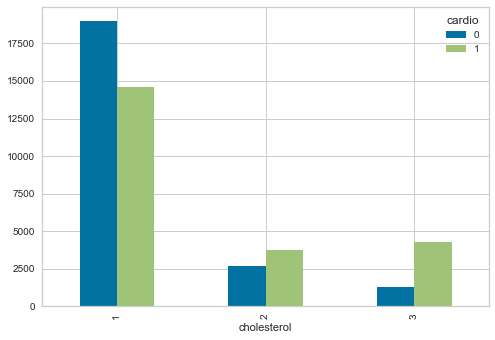

In [24]:
pd.crosstab(womendata.cholesterol,womendata.cardio).plot(kind='bar')

In [25]:
pd.crosstab(womendata.gluc,womendata.cardio)

cardio,0,1
gluc,,
1,20144,18306
2,1431,1985
3,1324,2319


<AxesSubplot:xlabel='gluc'>

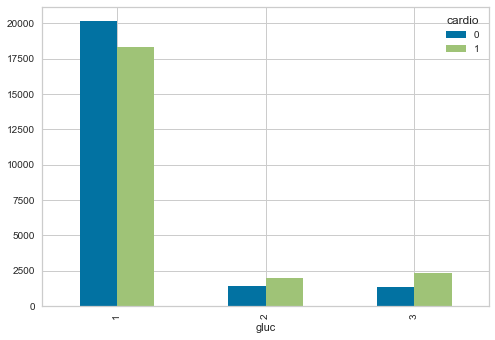

In [26]:
pd.crosstab(womendata.gluc,womendata.cardio).plot(kind='bar')

In [27]:
pd.crosstab(womendata.smoke,womendata.cardio)

cardio,0,1
smoke,,
0,22474,22222
1,425,388


<AxesSubplot:xlabel='smoke'>

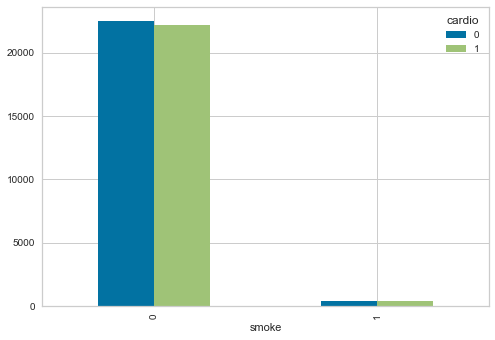

In [28]:
pd.crosstab(womendata.smoke,womendata.cardio).plot(kind='bar')

In [29]:
pd.crosstab(womendata.alco,womendata.cardio)

cardio,0,1
alco,,
0,22317,22031
1,582,579


<AxesSubplot:xlabel='alco'>

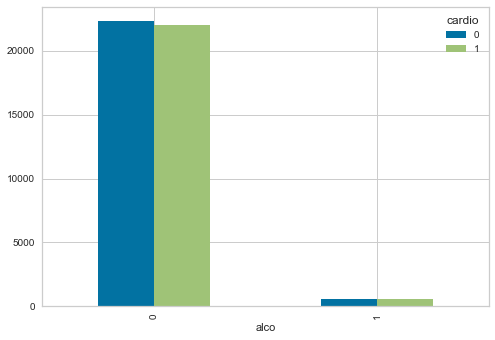

In [30]:
pd.crosstab(womendata.alco,womendata.cardio).plot(kind='bar')

In [31]:
pd.crosstab(womendata.active,womendata.cardio)

cardio,0,1
active,,
0,4263,4748
1,18636,17862


<AxesSubplot:xlabel='active'>

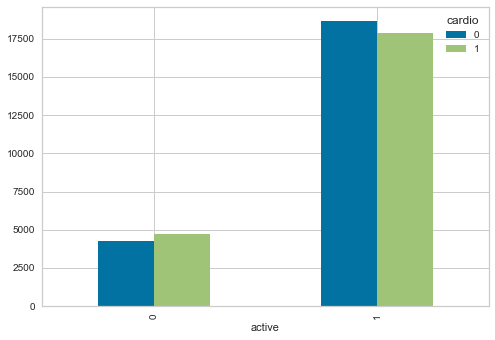

In [32]:
pd.crosstab(womendata.active,womendata.cardio).plot(kind='bar')

In [33]:
pd.crosstab(womendata.BMI,womendata.cardio)

cardio,0,1
BMI,,
8.001829,0,1
9.331007,1,0
9.917581,0,1
11.718750,0,1
12.254473,0,1
...,...,...
191.666667,1,0
237.768633,1,0
267.768595,0,1


In [34]:
womendata.head()

,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,year,height(m),BMI
1,85.0,140,90,3,1,0,0,1,1,55.0,1.56,34.927679
2,64.0,130,70,3,1,0,0,0,1,52.0,1.65,23.507805
4,56.0,100,60,1,1,0,0,0,0,48.0,1.56,23.011177
5,67.0,120,80,2,2,0,0,0,0,60.0,1.51,29.384676
6,93.0,130,80,3,1,0,0,1,0,61.0,1.57,37.729725


# Data Visualisation womendata

0 - noncardio, 1 - cardio
0    22899
1    22610
Name: cardio, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cardio', ylabel='count'>

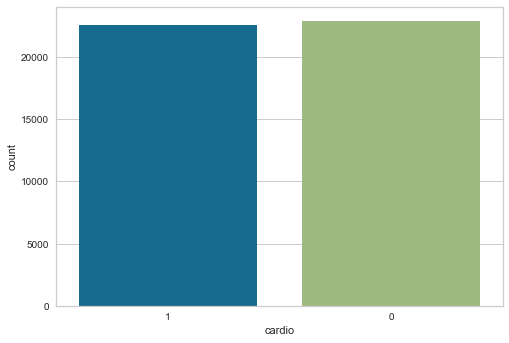

In [35]:
#for cardio
print("0 - noncardio, 1 - cardio")
x=(womendata.cardio.value_counts())
print(x)
sns.countplot(womendata["cardio"])

1: normal, 2: above normal, 3: well above normal
1    33549
2     6403
3     5557
Name: cholesterol, dtype: int64


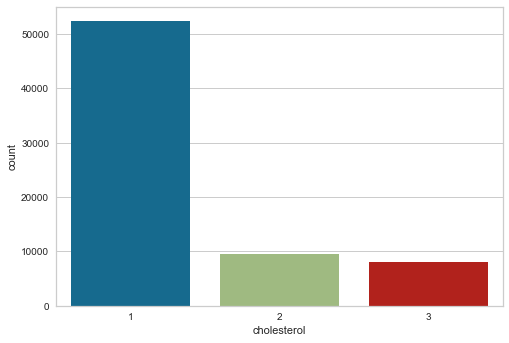

In [36]:
#for Cholesterol 
print("1: normal, 2: above normal, 3: well above normal")
x=(womendata.cholesterol.value_counts())
print(x)
p = sns.countplot(data=cardio, x="cholesterol")
plt.show()

0 - Non Smoker , 1 - Smoker
0    44696
1      813
Name: smoke, dtype: int64


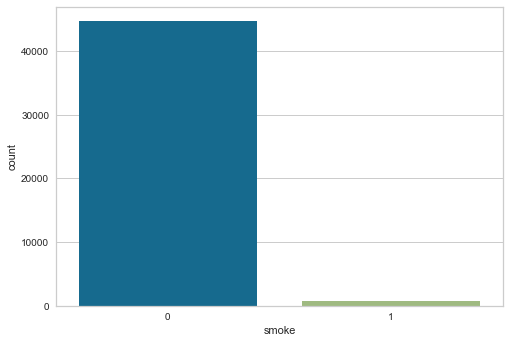

In [37]:
#for smokers
print("0 - Non Smoker , 1 - Smoker")
x=(womendata.smoke.value_counts())
print(x)
p = sns.countplot(data=womendata, x="smoke")
plt.show()

0 - Non alco , 1 - alco
0    44348
1     1161
Name: alco, dtype: int64


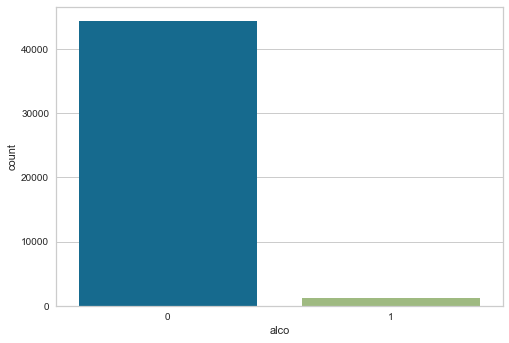

In [38]:
#for alcohol
print("0 - Non alco , 1 - alco")
x=(womendata.alco.value_counts())
print(x)
p = sns.countplot(data=womendata, x="alco")
plt.show()

<Figure size 3600x2880 with 0 Axes>

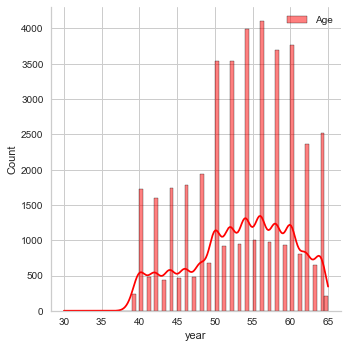

In [39]:
#Density Distribution for year
plt.figure(figsize=(50,40))
sns.displot(womendata.year, color="red", kde= True,label="Age")
plt.legend()

In [40]:
womendata.year()

TypeError: 'Series' object is not callable

In [ ]:
#Heart attack v/s year 
plt.figure(figsize=(20,10))
sns.histplot(womendata[womendata['cardio'] == 0]["year"], color='blue',kde=True) 
sns.histplot(womendata[womendata['cardio'] == 1]["year"], color='red',kde=True)
plt.title('Attack VS Year')
plt.show()

In [ ]:
womendata.head()

In [ ]:
#Kernal density estimate plot of all features in the dataset
num_feats = ['year', 'BMI', 'height(m)', 'weight', 'ap_hi', 'ap_lo','cholesterol','gluc','smoke','active']
mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']
L = len(num_feats)
ncol= 2
nrow= int(np.ceil(L/ncol))

fig, ax = plt.subplots(nrow, ncol, figsize=(15, 23),facecolor='#F6F5F4')   
fig.subplots_adjust(top=0.92)

i = 1
for col in num_feats:
    plt.subplot(nrow, ncol, i)
    
    ax = sns.kdeplot(data=womendata, x=col, hue="cardio", multiple="stack", palette=mypal[1::4]) 
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel("density", fontsize=20)
    sns.despine(right=True)
    sns.despine(offset=0, trim=False)
    
    i = i +1
plt.suptitle('Features kde-plot' ,fontsize = 24)

In [ ]:
#features count plot-fix the color
num = ['year', 'BMI', 'alco','cholesterol','gluc','smoke','active']
def hist_plot(womendata, num):    
    L = len(num)
    ncol= 2
    nrow= int(np.ceil(L/ncol))
    remove_last= (nrow * ncol) - L

    fig, ax = plt.subplots(nrow, ncol,figsize=(40, 25), facecolor='#FC05FB')    
    fig.subplots_adjust(top=0.92)
    ax.flat[-remove_last].set_visible(False)

    i = 1
    for col in num:
        plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')
        g = sns.countplot(data=womendata, x=col, hue="cardio", palette=mypal[1::4])
        g.set_xlabel(col, fontsize=20)
        g.set_ylabel("count", fontsize=20)
        sns.despine(right=True)
        sns.despine(offset=0, trim=False) 
        plt.legend(facecolor='#F6F5F5')
        i = i +1

    plt.suptitle('Features count-plot' ,fontsize = 24)
    return 0

hist_plot(womendata, num[0:-1]);

In [ ]:
#features pair plots
num_feats = ['year', 'BMI', 'weight', 'ap_hi', 'ap_lo','cholesterol','gluc','smoke','cardio']
data = cardio[num_feats]
g = sns.pairplot(data, hue="cardio", corner=True, diag_kind='hist')
plt.suptitle('Features pairplot' ,fontsize = 24);

In [ ]:
#strip plot of attributes v/s cardio
columns=womendata.columns

sns.set(rc={'figure.figsize':(20,20)})
j=1
sns.set_style(style='white')

for i in range(len(columns)):
    plt.subplot(7,2,j)
    sns.stripplot(x='cardio', y=columns[i] , data=cardio)
    j=j+1

In [ ]:
#Correlation of each feature in the dataset
corrmat = womendata.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(40,20))
sns.set(font_scale=2.5)
g=sns.heatmap(cardio[top_corr_features].corr(),annot=True,cmap="mako")

In [ ]:
#pair wise correlation matrix
corr_matrix = womendata.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 
sns.set(font_scale=1.5)
plt.figure(figsize=(20,15))
sns.despine(top=True, right=True, bottom=True)
g1 = sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1,annot=True, cmap="magma")
g1.set_title("Pairwise correlation matrix")

In [ ]:
#pair plot
plt.figure(figsize = (7,7))
sns.pairplot(womendata, hue='cardio')
plt.show()

In [ ]:
womendata.head()

In [ ]:
#setting up dependent and independent variables 
x = womendata.iloc[:, 0:-1]
y = womendata.iloc[:, -1]
x,y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [ ]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

In [ ]:
from sklearn import preprocessing
from sklearn import utils
lab = preprocessing.LabelEncoder()
X_transformed  = lab.fit_transform(y_train)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, X_transformed)

# Decision region drawing
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
   # setup marker generator and color map
   markers = ('s', 'x', 'o', '^', 'v')
   colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
   cmap = ListedColormap(colors[:len(np.unique(y))])

   # plot the decision surface
   x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
   x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
   xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
   np.arange(x2_min, x2_max, resolution))
   Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
   Z = Z.reshape(xx1.shape)
   plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
   plt.xlim(xx1.min(), xx1.max())
   plt.ylim(xx2.min(), xx2.max())

   # plot all samples
   X_test, y_test = X[test_idx, :], y[test_idx]
   for idx, cl in enumerate(np.unique(y)):
      plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
               alpha=0.8, c=cmap(idx),
               marker=markers[idx], label=cl)
   # highlight test samples
   if test_idx:
      X_test, y_test = X[test_idx, :], y[test_idx]
      plt.scatter(X_test[:, 0], X_test[:, 1], c='',
               alpha=1.0, linewidth=1, marker='o',
               s=55, label='test set')

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std,
                      y_combined, classifier=lr,
                      test_idx=range(105,150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()